<a href="https://colab.research.google.com/github/MuskanSinhaPi/Intern/blob/main/clustering_text_into_representational_samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports the libraries and read the data files
from google.colab import drive
import random
import re
from nltk.stem.snowball import SnowballStemmer
import os
import gensim
from gensim.models import Doc2Vec, Word2Vec
from nltk.corpus import stopwords
import nltk
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import normalize
import time

"""### Downloading extra dependencies from NLTK"""
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
start_time = time.time()

In [ ]:
#Getting stopwords customized to the dataset
drive.mount('/content/drive')

path = Path('/content/drive/MyDrive/internship/Datasets/Articles')
seed = 137

def load_data_st(path,seed):
    train_texts = []
    for file_path in sorted(path.glob('*.txt')):
        with open(file_path, 'r', encoding='ISO-8859-1') as f:
            train_texts.append(f.read())
    random.seed(seed)
    random.shuffle(train_texts)
    return train_texts

# Call the load_data function with the updated path
documents = load_data_st(path,seed)

def get_suggestive_stopwords(documents, max_stopwords=60):
    # Create TfidfVectorizer instance
    tfidf_vectorizer = TfidfVectorizer()

    # Fit the vectorizer to the documents
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

    # Get feature names (terms/words)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Calculate average TF-IDF scores for each term
    avg_tfidf_scores = np.mean(tfidf_matrix, axis=0)

    # Convert average TF-IDF scores to 1D array
    avg_tfidf_scores = np.asarray(avg_tfidf_scores).ravel()

    # Sort terms by their average TF-IDF scores
    sorted_indices = np.argsort(avg_tfidf_scores)[::-1]

    # Get the top suggestive stopwords based on average TF-IDF scores
    if max_stopwords < len(feature_names):
        top_stopwords = [feature_names[idx] for idx in sorted_indices[:max_stopwords]]
    else:
        top_stopwords = [feature_names[idx] for idx in sorted_indices]

    return top_stopwords

# Get suggestive stopwords
stopwords = get_suggestive_stopwords(list(documents))

print("Suggestive stopwords based on average TF-IDF scores:")
print(stopwords)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Suggestive stopwords based on average TF-IDF scores:
['the', 'of', 'to', 'and', 'in', 'is', 'that', 'for', 'it', 'are', 'cricket', 'with', 'as', 'on', 'be', 'was', 'you', 'neural', 'can', 'this', 'have', 'from', 'or', 'by', 'networks', 'an', 'its', 'will', 'has', 'food', 'at', 'but', 'your', 'mr', 'they', 'like', 'apple', 'were', 'more', 'cbd', 'chinese', 'team', '½s', 'would', 'which', 'their', 'there', 'these', 'we', 'about', 'time', 'not', 'what', 'one', 'he', 'said', 'restaurants', 'many', 'how', 'his']


In [ ]:
# Tokenizing the document and filtering the tokens
def tokenize(train_texts):
    filtered_tokens = []
    tokens = [word for sent in nltk.sent_tokenize(train_texts) for word in nltk.word_tokenize(sent)]
    for token in tokens:
        re.sub(r'[^\w\s]', '', token) # Remove punctuation, special characters, and newline characters
        if re.search('[a-zA-Z]', token):
            if (('http' not in token) and ('@' not in token) and ('<.*?>' not in token) and token.isalnum() and (
            not token in list(stopwords))):
                filtered_tokens.append(token)
    return filtered_tokens

In [ ]:
# Tokenizing and stemming using Snowball stemmer
def tokenize_stem_lemma(train_texts):
    tokens = tokenize(train_texts)
    stemmer = SnowballStemmer('english')
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    wordnet = WordNetLemmatizer()
    lemma_stemmed_tokens = [wordnet.lemmatize(token) for token in stemmed_tokens]

    return lemma_stemmed_tokens

In [ ]:
# Loading Data

path = Path('/content/drive/MyDrive/internship/Datasets/Articles') #path to Articles folder
seed = 137

def load_data(path,seed):
    train_texts = []
    doc_names=[]
    for file_path in sorted(path.glob('*.txt')):
        doc_names.append(file_path.stem)
        with open(file_path, 'r', encoding='ISO-8859-1') as f:
            train_texts.append(f.read())
    # Combine texts and names into pairs, shuffle, and then unzip
    combined = list(zip(train_texts, doc_names))
    random.seed(seed)
    random.shuffle(combined)
    train_texts, doc_names = zip(*combined)

    return list(train_texts), list(doc_names)

# Call the load_data function with the updated path
train_texts, doc_names = load_data(path,seed)

In [ ]:
!pip install nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#Create a list of tokenised documents
# LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content = []
j = 0
k = 0

vocab_tokenized = []
for line in train_texts:
    allwords_stemmed_lemma = tokenize_stem_lemma(line)
    vocab_tokenized.append(allwords_stemmed_lemma)

for text in vocab_tokenized:
    # add tokens to list
    if len(text) > 0:
        all_content.append(text)
        j += 1
    k += 1

all_content = [" ".join(tokens) for tokens in vocab_tokenized]

print("Number of documents processed: ", k)
print("Number of non-empty document vectors: ", j)

Number of documents processed:  34
Number of non-empty document vectors:  33


In [ ]:
# #Create a model using Doc2Vec and train it

# d2v_model = Doc2Vec(all_content, vector_size=300, min_count=5, dm=0,alpha=0.0025, min_alpha=0.0001, seed=0)
# d2v_model.random.seed(0)
# d2v_model.train(all_content, total_examples=d2v_model.corpus_count, epochs=100, start_alpha=0.002, end_alpha=-0.016)


In [ ]:
#perform PCA

# # Step 1: Extract vectors from the trained Doc2Vec model
# vectors = [d2v_model.dv[i] for i in range(len(all_content))]

# # Step 2: Normalize the vectors
# normalized_vectors = normalize(vectors)

# # Step 3: Perform PCA on the normalized vectors
# pca = PCA(n_components=2)
# pca_vectors = pca.fit_transform(normalized_vectors)

In [ ]:
# Step 1: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_content)

# Get the number of dimensions (features)
num_dimensions = tfidf_matrix.shape[1]

print(f"Number of dimensions in TF-IDF vectors: {num_dimensions}")

# Step 2: Normalize the vectors
normalized_tfidf = normalize(tfidf_matrix)

# Step 3: Perform PCA on the normalized vectors
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(normalized_tfidf.toarray())

# Step 4: Obtain the document coordinates
document_coordinates = pca.transform(normalized_tfidf.toarray())

# Print the document coordinates
print(document_coordinates)

Number of dimensions in TF-IDF vectors: 3756
[[-0.15494847  0.02638775]
 [-0.39013935  0.37057968]
 [ 0.0879983  -0.0835285 ]
 [-0.00711694  0.00648267]
 [ 0.33416869  0.08866591]
 [ 0.3391939   0.06503555]
 [-0.07299958 -0.13306777]
 [ 0.26923848  0.03138214]
 [ 0.0628918   0.05193736]
 [-0.37078859  0.36734301]
 [ 0.37427478  0.08178083]
 [-0.22553797  0.26968661]
 [-0.20431067 -0.36119357]
 [ 0.09091742 -0.08637454]
 [-0.01559081  0.13631835]
 [ 0.02790445  0.15591217]
 [-0.35858717  0.4266431 ]
 [-0.15964665 -0.19875204]
 [-0.04787749 -0.25636343]
 [ 0.2587703   0.07564324]
 [-0.02522408  0.11791132]
 [ 0.00560312  0.06232748]
 [-0.18452157 -0.243348  ]
 [-0.16617353 -0.30526647]
 [-0.09929669 -0.35727215]
 [ 0.40588583  0.06374195]
 [-0.02465817 -0.02554625]
 [-0.19577881 -0.25948754]
 [ 0.02817336 -0.02648942]
 [ 0.05474156 -0.02877056]
 [ 0.11199517  0.01856199]
 [-0.00310992  0.18115803]
 [-0.10271103 -0.32290749]
 [ 0.35726035  0.09086857]]


In [ ]:
# document_names = tfidf_vectorizer.inverse_transform(normalized_tfidf)

# for i, document_name in enumerate(document_names):
#     print(f"Row {i}: {document_name}")

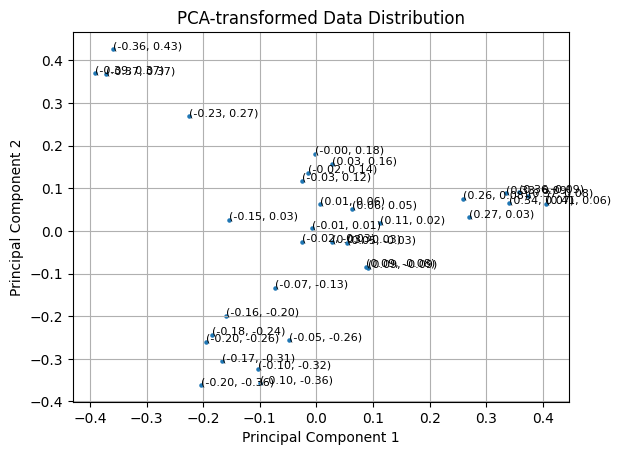

In [ ]:
# Plot PCA-transformed data to inspect the distribution
plt.figure()
plt.scatter(pca_vectors[:, 0], pca_vectors[:, 1], s=5)

# Annotate each point with its coordinates
for i in range(len(pca_vectors)):
    plt.text(pca_vectors[i, 0], pca_vectors[i, 1], f'({pca_vectors[i, 0]:.2f}, {pca_vectors[i, 1]:.2f})', fontsize=8)

plt.title('PCA-transformed Data Distribution')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
# Imports the libraries and read the data files
!pip install --upgrade gensim

# Elbow Method
nc = range(1, 10)
kmeans = [KMeans(n_clusters=i, n_init=10000, max_iter=15000) for i in nc]

# Check if d2v_model.docvecs has a 'vectors' attribute
if hasattr(pca_vectors, 'vectors'):
    score = [-kmeans[i].fit(pca_vectors).score(pca_vectors) for i in range(len(kmeans))]
else:
    # Use the correct attribute name based on the updated Gensim documentation
    score = [-kmeans[i].fit(pca_vectors).score(pca_vectors) for i in range(len(kmeans))]

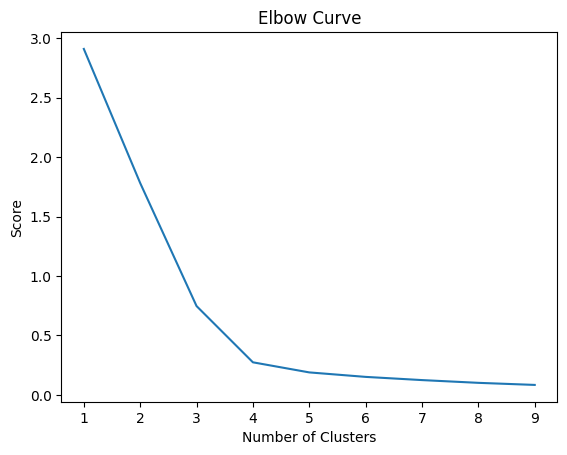

In [ ]:
# Plot the elbow
plt.plot(nc, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def silhouette_method(X, max_k=10):
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pca_vectors)
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append((k, score))

    best_k = max(silhouette_scores, key=lambda item: item[1])[0]
    return best_k, silhouette_scores

# silhouette score
best_k, scores = silhouette_method(pca_vectors)
print(f"Best k based on silhouette score: {best_k}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Best k based on silhouette score: 4


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Apply K-means clustering on the model
K_value = 4
# Calculate the range of the PCA-transformed data along each principal component
x_min, x_max = np.min(pca_vectors[:, 0]), np.max(pca_vectors[:, 0])
y_min, y_max = np.min(pca_vectors[:, 1]), np.max(pca_vectors[:, 1])

# Generate evenly spaced points within this range
x_coords = np.linspace(x_min, x_max, K_value)
y_coords = np.linspace(y_min, y_max, K_value)
initial_centroids = np.array(list(zip(x_coords, y_coords)))

# Ensure that the number of initial centroids matches K_value
assert initial_centroids.shape[0] == K_value, "Number of initial centroids must match K_value"

# Print initial centroids for debugging
print("Initial centroids:")
print(initial_centroids)

kmeans_model = KMeans(n_clusters=K_value,  random_state=1, init=initial_centroids, n_init=2000, max_iter=10000,tol=1e-4)

# Fit the K-means model once
clusters = kmeans_model.fit_predict(pca_vectors)

Initial centroids:
[[-0.39013935 -0.36119357]
 [-0.12479762 -0.09858135]
 [ 0.1405441   0.16403087]
 [ 0.40588583  0.4266431 ]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=2000.
  super()._check_params_vs_input(X, default_n_init=10)


Centroid C1: (-0.14, -0.27)
Centroid C2: (0.02, 0.04)
Centroid C3: (0.33, 0.07)
Centroid C4: (-0.34, 0.36)


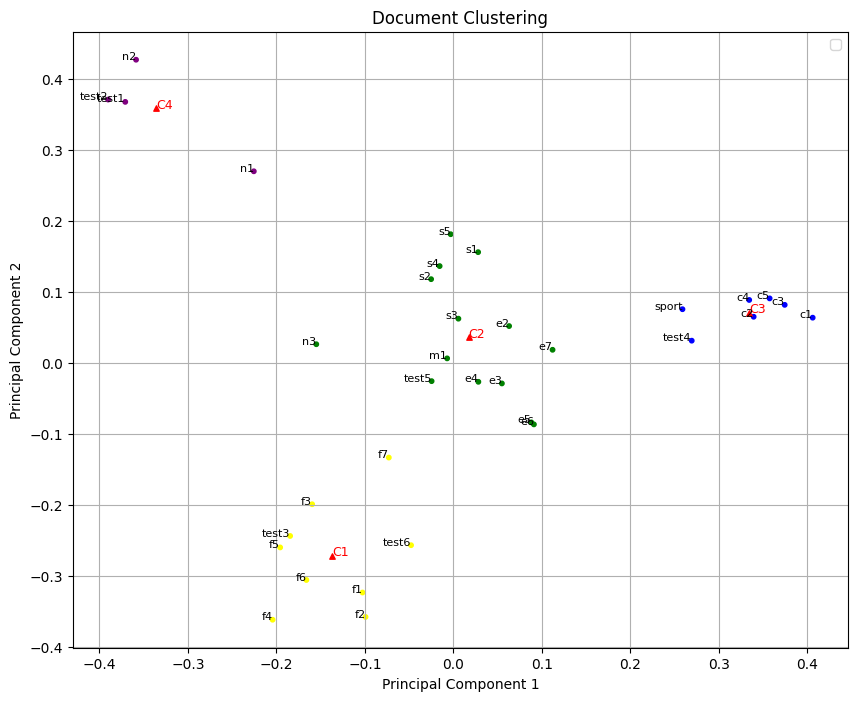

In [ ]:
# Plot the clustering result
plt.figure(figsize=(10, 8))
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#FFC0CB", "#000080","#F04080", "#F05090"]
color = [label1[i] for i in clusters]
plt.scatter(pca_vectors[:, 0], pca_vectors[:, 1], s=10, c=color)

centroidpoint = kmeans_model.cluster_centers_
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=15, c='#FF0000')

# Annotate centroids with their coordinates
for i, (x, y) in enumerate(centroidpoint):
    plt.text(x, y, f'C{i+1}', fontsize=9, ha='left', c='#FF0000')
    print(f"Centroid C{i+1}: ({x:.2f}, {y:.2f})")

# Annotate each data point with the document label
for i, txt in enumerate(doc_names):
    plt.annotate(txt, (pca_vectors[i, 0], pca_vectors[i, 1]), fontsize=8, ha='right')

plt.title('Document Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# End time measurement
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

Execution time: 213.64 seconds


<hr width=100%>

## Clustering on 20 NewsGroup Corpus

In [ ]:
start_time = time.time()

###Loading the dataset from drive (since fetching from sklearn leads to HTTP Error 403)

In [ ]:
def clean_document(document):
    # Remove headers
    document = re.sub(r'^Lines: \d+', '', document, flags=re.MULTILINE)
    # Remove footers
    document = re.sub(r'(?m)^\s*--\s*$', '', document)
    # Remove quotes
    document = re.sub(r'^\s*>.*\n?', '', document, flags=re.MULTILINE)
    # Remove author lines
    document = re.sub(r'^.*writes:\n?', '', document, flags=re.MULTILINE)
    return document.strip()

def load_category_data(directory, categories):
    doc_names=[]
    train_texts = []
    for category in categories:
        category_path = os.path.join(directory, category)
        print('{} contains {} Files'.format(category,len(os.listdir(category_path))))
        for filename in os.listdir(category_path):
            doc_names.append(filename)
            file_path = os.path.join(category_path, filename)
            with open(file_path, 'r', encoding='ISO-8859-1') as file:
                doc_unprocessed = file.read()
                docs = clean_document(doc_unprocessed)
                train_texts.append(docs)

    # Combine texts and names into pairs, shuffle, and then unzip
    combined = list(zip(train_texts, doc_names))
    random.seed(seed)
    random.shuffle(combined)
    train_texts, doc_names = zip(*combined)

    return list(train_texts), list(doc_names)

seed=256

# Specify the path to the base directory containing the 20 newsgroups dataset
base_directory = Path('/content/drive/MyDrive/internship/Datasets/20newsGroup')

# Specify the categories you are interested in
categories = ['sci.space', 'rec.sport.baseball', 'comp.graphics', 'talk.politics.misc']

# Load the dataset for the specified categories
corpus, doc_names = load_category_data(base_directory, categories)

# Now, `texts` contains the cleaned documents and `labels` contains the corresponding category labels.


sci.space contains 593 Files
rec.sport.baseball contains 597 Files
comp.graphics contains 584 Files
talk.politics.misc contains 465 Files


###Stopwords

In [ ]:
#Stopwords
def get_suggestive_stopwords(documents, max_stopwords=120):
    # Create TfidfVectorizer instance
    tfidf_vectorizer = TfidfVectorizer()

    # Fit the vectorizer to the documents
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

    # Get feature names (terms/words)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Calculate average TF-IDF scores for each term
    avg_tfidf_scores = np.mean(tfidf_matrix, axis=0)

    # Convert average TF-IDF scores to 1D array
    avg_tfidf_scores = np.asarray(avg_tfidf_scores).ravel()

    # Sort terms by their average TF-IDF scores
    sorted_indices = np.argsort(avg_tfidf_scores)[::-1]

    # Get the top suggestive stopwords based on average TF-IDF scores
    if max_stopwords < len(feature_names):
        top_stopwords = [feature_names[idx] for idx in sorted_indices[:max_stopwords]]
    else:
        top_stopwords = [feature_names[idx] for idx in sorted_indices]

    return top_stopwords

# Get suggestive stopwords
stopwords = get_suggestive_stopwords(list(corpus))

print("Suggestive stopwords based on average TF-IDF scores:")
print(stopwords)

Suggestive stopwords based on average TF-IDF scores:
['the', 'to', 'of', 'and', 'in', 'is', 'that', 'edu', 'it', 'for', 'you', 'from', 'on', 'this', 'be', 'have', 'com', 'was', 'not', 'are', 're', 'as', 'with', 'they', 'subject', 'organization', 'or', 'if', 'but', 'he', 'at', 'university', 'would', 'can', 'posting', 'space', 'what', 'by', 'nntp', 'host', 'there', 'will', 'all', 'we', 'about', 'one', 'do', 'my', 'an', 'so', 'don', 'out', 'has', 'me', 'any', 'just', 'like', 'some', 'no', 'who', 'your', 'more', 'cs', 'up', 'how', 'think', 'nasa', 'his', 'know', 'article', 'people', 'ca', 'which', 'year', 'distribution', 'than', 'get', 'graphics', 'new', 'were', 'their', 'when', 'had', 'good', 'been', 'other', 'only', 'why', 'time', 'state', 'does', 'could', 'world', 'also', 'reply', 'first', 'them', 'gov', 'access', 'anyone', 'thanks', 'much', 'henry', 'then', 'usa', 'am', 'very', 'well', 'toronto', 'mail', 'now', 'where', 'need', 'use', 'software', 'into', 'computer', 'should', 'see', 'e

###Tokenisation->Stemming->Lemmatisation

In [ ]:
#Create a list of tokenised documents
all_content = []
j = 0
k = 0

vocab_tokenized = []
for line in corpus:
    allwords_stemmed_lemma = tokenize_stem_lemma(line)
    vocab_tokenized.append(allwords_stemmed_lemma)

for text in vocab_tokenized:
    # add tokens to list
    if len(text) > 0:
        all_content.append(text)
        j += 1
    k += 1

all_content = [" ".join(tokens) for tokens in vocab_tokenized]

print("Number of documents processed: ", k)
print("Number of non-empty document vectors: ", j)

Number of documents processed:  2239
Number of non-empty document vectors:  2239


###TF-IDF Vectorization followed by Dimensionality Reduction using PCA

In [ ]:
# Step 1: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_content)

# Get the number of dimensions (features)
num_dimensions = tfidf_matrix.shape[1]

print(f"Number of dimensions in TF-IDF vectors: {num_dimensions}")

# Step 2: Normalize the vectors
normalized_tfidf = normalize(tfidf_matrix)

# Step 3: Perform PCA on the normalized vectors
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(normalized_tfidf.toarray())

# Step 4: Obtain the document coordinates
document_coordinates = pca.transform(normalized_tfidf.toarray())

Number of dimensions in TF-IDF vectors: 19099


###Plotting the PCA vectors

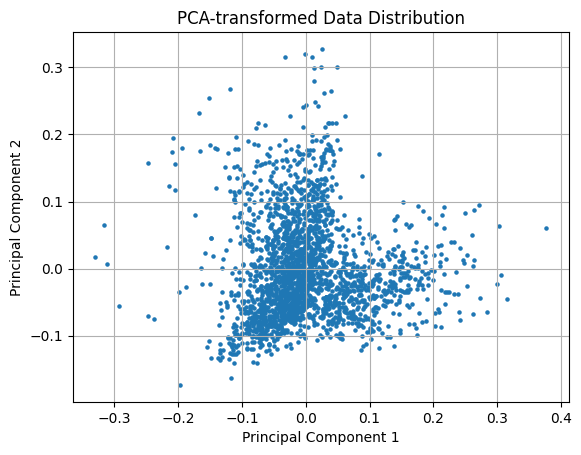

In [ ]:
# Plot PCA-transformed data to inspect the distribution
plt.figure()
plt.scatter(pca_vectors[:, 0], pca_vectors[:, 1], s=5)

# # Annotate each point with its coordinates
# for i in range(len(pca_vectors)):
#     plt.text(pca_vectors[i, 0], pca_vectors[i, 1], f'({pca_vectors[i, 0]:.2f}, {pca_vectors[i, 1]:.2f})', fontsize=8)

plt.title('PCA-transformed Data Distribution')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

###Evaluating Optimum K-value

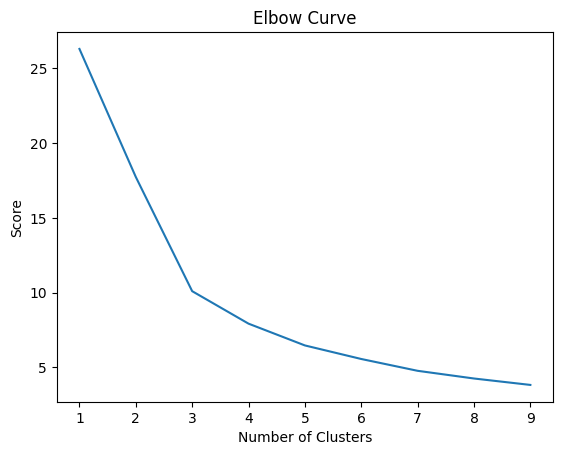

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

******************************
Best k based on silhouette score: 3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Imports the libraries and read the data files
!pip install --upgrade gensim

# Elbow Method
nc = range(1, 10)
kmeans = [KMeans(n_clusters=i, n_init=10000, max_iter=15000) for i in nc]

# Check if d2v_model.docvecs has a 'vectors' attribute
if hasattr(pca_vectors, 'vectors'):
    score = [-kmeans[i].fit(pca_vectors).score(pca_vectors) for i in range(len(kmeans))]
else:
    # Use the correct attribute name based on the updated Gensim documentation
    score = [-kmeans[i].fit(pca_vectors).score(pca_vectors) for i in range(len(kmeans))]

# Plot the elbow
plt.plot(nc, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

best_k, scores = silhouette_method(pca_vectors)
print('*'*30)
print(f"Best k based on silhouette score: {best_k}")

###Applying K-Means Clustering

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Apply K-means clustering on the model
K_value = 4
# Calculate the range of the PCA-transformed data along each principal component
x_min, x_max = np.min(pca_vectors[:, 0]), np.max(pca_vectors[:, 0])
y_min, y_max = np.min(pca_vectors[:, 1]), np.max(pca_vectors[:, 1])

# Generate evenly spaced points within this range
x_coords = np.linspace(x_min, x_max, K_value)
y_coords = np.linspace(y_min, y_max, K_value)
initial_centroids = np.array(list(zip(x_coords, y_coords)))

# Ensure that the number of initial centroids matches K_value
assert initial_centroids.shape[0] == K_value, "Number of initial centroids must match K_value"

# Print initial centroids for debugging
print("Initial centroids:")
print(initial_centroids)

kmeans_model = KMeans(n_clusters=K_value,  random_state=1, init=initial_centroids, n_init=2000, max_iter=10000,tol=1e-4)

# Fit the K-means model once
clusters = kmeans_model.fit_predict(pca_vectors)

Initial centroids:
[[-0.3297244  -0.17325926]
 [-0.09414531 -0.00635183]
 [ 0.14143378  0.1605556 ]
 [ 0.37701287  0.32746302]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=2000.
  super()._check_params_vs_input(X, default_n_init=10)


###Plotting Clustering Results

Centroid C1: (-0.07, -0.07)
Centroid C2: (-0.00, -0.00)
Centroid C3: (0.13, -0.03)
Centroid C4: (-0.02, 0.12)


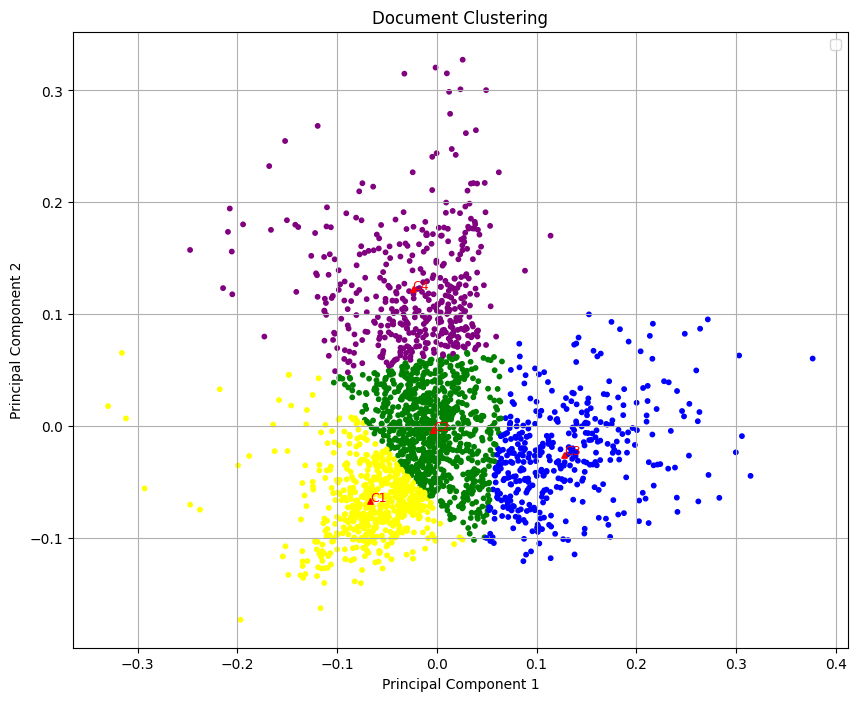

In [ ]:
# Plot the clustering result
plt.figure(figsize=(10, 8))
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#FFC0CB", "#000080","#F04080", "#F05090"]
color = [label1[i] for i in clusters]
plt.scatter(pca_vectors[:, 0], pca_vectors[:, 1], s=10, c=color)

centroidpoint = kmeans_model.cluster_centers_
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=15, c='#FF0000')

# Annotate centroids with their coordinates
for i, (x, y) in enumerate(centroidpoint):
    plt.text(x, y, f'C{i+1}', fontsize=9, ha='left', c='#FF0000')
    print(f"Centroid C{i+1}: ({x:.2f}, {y:.2f})")

# # Annotate each data point with the document label
# for i, txt in enumerate(doc_names):
#     plt.annotate(txt, (pca_vectors[i, 0], pca_vectors[i, 1]), fontsize=8, ha='right')

plt.title('Document Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# End time measurement
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

Execution time: 510.09 seconds


In [ ]:
# Find the number of data points in each cluster
unique_labels, counts = np.unique(clusters, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label+1}: {count} data points")

Cluster 1: 563 data points
Cluster 2: 856 data points
Cluster 3: 402 data points
Cluster 4: 418 data points
